In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
from scipy.stats import bartlett, levene, jarque_bera, normaltest

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices_df = pd.read_sql_query('select * from houseprices', con=engine)

engine.dispose()

In [3]:
#Quick check on the number of rows and the columns in the dataframe
print(len(house_prices_df))
house_prices_df.iloc[:,:81].head(5)

1460


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


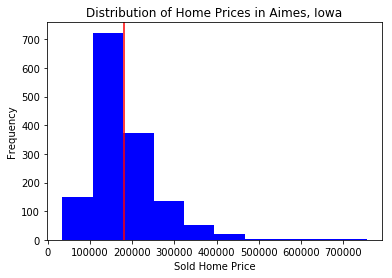

Mean house price in Aimes:  180921.19589041095


In [4]:
#Since we are estimating the saleprice I want to check the distribution
plt.hist(house_prices_df['saleprice'], color ='b')
plt.xlabel('Sold Home Price')
plt.ylabel('Frequency')
plt.axvline(house_prices_df['saleprice'].mean(), color='r', alpha=1.0)
plt.title('Distribution of Home Prices in Aimes, Iowa')
plt.show()
print('Mean house price in Aimes: ', house_prices_df['saleprice'].mean())

The sale price of the homes in Aimes, Iowa seems to be right-skewed with a few homes selling in the $ 700,000 range and the mean price at $ 180,000. Next, I want to dig into some of the variables and determine whether or not they would be a good fit for the model. Most of the data is categorical with string values for different classifiers, so the following evaluation will include digging into most of them one by one.

### Feature Engineering

In [5]:
house_prices_df['total_sf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

In [6]:
num_car_garage = pd.get_dummies(house_prices_df['garagecars'], prefix='car_garage')
house_prices_df = pd.concat([house_prices_df, num_car_garage], axis=1)


In [7]:
garage_type = pd.get_dummies(house_prices_df['garagetype'], prefix='garagetype')
house_prices_df = pd.concat([house_prices_df, garage_type], axis=1)


In [8]:
paved = pd.get_dummies(house_prices_df['paveddrive'], prefix='paved_driveway')
house_prices_df = pd.concat([house_prices_df, paved], axis=1)

In [9]:
garage_finish = pd.get_dummies(house_prices_df['garagefinish'], prefix='garagefinish')
house_prices_df = pd.concat([house_prices_df, garage_finish], axis=1)

In [10]:
#Does the house have an above average kitchen feature
house_prices_df['awesome_kitchen'] = 9999

In [11]:
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Ex') | (house_prices_df['kitchenqual'] == 'Gd'), 
                    ['awesome_kitchen']] = 1
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Fa') | (house_prices_df['kitchenqual'] == 'TA'), 
                    ['awesome_kitchen']] = 0
house_prices_df.awesome_kitchen.value_counts()

0    774
1    686
Name: awesome_kitchen, dtype: int64

In [12]:
#Is the garage attached to the house feature
house_prices_df['attached_garage'] = 9999
house_prices_df.loc[(house_prices_df['garagetype'] == 'Attchd') | (house_prices_df['garagetype'] == 'BuiltIn'), 
                    ['attached_garage']] = 1
house_prices_df.loc[(house_prices_df['garagetype'] != 'Attchd') & (house_prices_df['garagetype'] != 'BuiltIn'), 
                    ['attached_garage']] = 0
house_prices_df.attached_garage.value_counts()

1    958
0    502
Name: attached_garage, dtype: int64

In [18]:
house_prices_df['yard_sf'] = house_prices_df['lotarea'] - house_prices_df['firstflrsf']

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: landcontour, dtype: int64


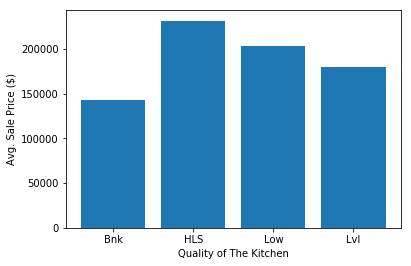

In [24]:
hillside = pd.get_dummies(house_prices_df['landcontour'], prefix='landcontour')
house_prices_df = pd.concat([house_prices_df, hillside], axis=1)

print(house_prices_df.landcontour.value_counts())

plt.bar(
    house_prices_df.groupby('landcontour')['saleprice'].mean().index,
    house_prices_df.groupby('landcontour')['saleprice'].mean()
)
plt.xlabel('Quality of The Kitchen')
plt.ylabel('Avg. Sale Price ($)')
plt.show()

### Linear Regression Modeling

In [13]:
#1st iteration
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'garagetype_2Types',
                    'garagetype_Basment', 
                    'garagetype_CarPort', 
                    'car_garage_3', 
                    'garagefinish_Fin'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     492.2
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        06:05:54   Log-Likelihood:                -17522.
No. Observations:                1460   AIC:                         3.506e+04
Df Residuals:                    1450   BIC:                         3.512e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               8579.3531   4810.992      1.783      0.075    -857.895     1.8e+04
awesome_kitchen     3.079e+04   2431.741     12.661      0.000     2.6e+04    3.56e+04
total_sf              48.4512      1.593     30.410      0.000      45.326      51.577
paved_driveway_Y    1.292e+04   4008.444      3.223      0.001    5055.399    2.08e+04
attached_garage     1.471e+04   2659.821      5.530      0.000    9491.749    1.99e+04
garagetype_2Types  -6.114e+04   1.64e+04     -3.723      0.000   -9.34e+04   -2.89e+04
garagetype_Basment  1.025e+04   9312.364      1.101      0.271   -8017.141    2.85e+04
garagetype_CarPort -1.019e+04   1.33e+04     -0.764      0.445   -3.63e+04     1.6e+04
car_garage_3        6.142e+04   3697.788     16.610      0.000    5.42e+04    6.87e+04
garagefinish_Fin     1.89e+04   2673.852      7.069      0.000    1.37e+04    2.41e+04
==============================================================================
Omnibus:                      503.677   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42867.956
Skew:                          -0.654   Prob(JB):                         0.00
Kurtosis:                      29.514   Cond. No.                     4.28e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 1st iteration evaluation

In this iteration of the model the R-sq = 0.753, Adj. R-sq = 0.752, F-statistic = 492.2, and the p-value of the F-test is 0.00. The AIC and BIC are 3.506e+04 and 3.512e+04 respectively. Based on those results this isn't a terrible model, but it can definitely be improved.  

In [14]:
#2nd iteration, removed statistically insignificant features
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'garagetype_2Types', 
                    'car_garage_3', 
                    'garagefinish_Fin'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     632.6
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        06:05:54   Log-Likelihood:                -17523.
No. Observations:                1460   AIC:                         3.506e+04
Df Residuals:                    1452   BIC:                         3.510e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              8424.1056   4808.456      1.752      0.080   -1008.158    1.79e+04
awesome_kitchen     3.08e+04   2429.127     12.679      0.000     2.6e+04    3.56e+04
total_sf             48.5454      1.590     30.522      0.000      45.425      51.665
paved_driveway_Y   1.312e+04   3996.954      3.282      0.001    5278.756     2.1e+04
attached_garage    1.438e+04   2606.538      5.515      0.000    9262.173    1.95e+04
garagetype_2Types -6.136e+04   1.64e+04     -3.738      0.000   -9.36e+04   -2.92e+04
car_garage_3       6.127e+04   3695.297     16.580      0.000     5.4e+04    6.85e+04
garagefinish_Fin   1.904e+04   2670.962      7.129      0.000    1.38e+04    2.43e+04
==============================================================================
Omnibus:                      506.307   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43128.854
Skew:                          -0.663   Prob(JB):                         0.00
Kurtosis:                      29.593   Cond. No.                     4.27e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In the 2nd iteration of the model, I removed some features, which brought the F-statistic up to 632.6 without effecting the R-sq values. The AIC value is identical to the 1st iteration, but the BIC value decreased by 20 to 3.510e+04.

In [26]:
#3rd iteration, including new features
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'garagetype_2Types', 
                    'car_garage_3', 
                    'garagefinish_Fin', 
                    'yard_sf', 
                    'landcontour_HLS'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     507.0
Date:                Sun, 23 Jun 2019   Prob (F-statistic):               0.00
Time:                        06:32:20   Log-Likelihood:                -17506.
No. Observations:                1460   AIC:                         3.503e+04
Df Residuals:                    1450   BIC:                         3.508e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              7166.9575   4760.756      1.505      0.132   -2171.748    1.65e+04
awesome_kitchen    3.184e+04   2414.600     13.187      0.000    2.71e+04    3.66e+04
total_sf             46.6634      1.631     28.603      0.000      43.463      49.864
paved_driveway_Y   1.438e+04   3958.567      3.632      0.000    6613.141    2.21e+04
attached_garage    1.356e+04   2582.808      5.249      0.000    8491.365    1.86e+04
garagetype_2Types -6.653e+04   1.63e+04     -4.093      0.000   -9.84e+04   -3.46e+04
car_garage_3       6.111e+04   3670.126     16.652      0.000    5.39e+04    6.83e+04
garagefinish_Fin   1.851e+04   2643.170      7.002      0.000    1.33e+04    2.37e+04
yard_sf               0.4743      0.110      4.331      0.000       0.259       0.689
landcontour_HLS    2.077e+04   5688.093      3.651      0.000    9612.027    3.19e+04
==============================================================================
Omnibus:                      552.824   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50873.137
Skew:                          -0.805   Prob(JB):                         0.00
Kurtosis:                      31.874   Cond. No.                     2.18e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For the 3rd iteration I added two new variables, 'yard_sf' (continuous variable represents the size of the yard) and the 'landcontour_HLS' (binary variable dictating whether a house is located on a hillside or not). Both of the new variables are statistically significant, have increased the p-value, and decreased the f-statistic (compared to the 2nd iteration). The AIC and BIC have both come down from both iterations. Neither have come down very much, but they are still lower than either of the first two models. Because of the higher R-squared value and lower AIC/BIC I think the 3rd model is the best one so far.